# Chapter 6 - Exercises

## Set Up

### Packages

In [1]:
import os

import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr
from numpy.polynomial import polynomial as poly
from scipy import stats
from scipy.special import expit, logit, logsumexp, softmax
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [2]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
CHIMPANZEES_FILE = "chimpanzees.csv"
ADMISSIONS_FILE = "ucbadmit.csv"
KLINE_FILE = "kline.csv"
REEDFROGS_FILE = "reedfrogs.csv"
CARS_FILE = "cars.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

## Easy

### 6E1

List three mechanisms by which multiple regression can product false inferences about causal effects.

---

**Multicollinearity:** If two predictors are highly correlated this can confound inferences.
For example if two predictors are negatively correlated, but both positively correlated with the outcome, then modelled individually they may appear to each have a strong causal effect, but together they may appear to have no effect.

**Collider bias:** If two, unrelated, variables $X$ and $Y$ have a causal effect on a third $Z$, then conditioning on $Z$ can induce associations between $X$ and $Y$.
This is sometimes known as Berkson's paradox.

**Post-treatment bias:** Conditioning on a variable downstream of the variable of interest can frustrate the causal inference.
For example, if we want to understand the causal effect of an individual's parents' income on life expectancy, then conditioning on the individual's income might lead us to believe that parents' income has no causal effect.
But, this is disregarding the causal effect of parents' income on individual income.

### 6E2
For one of the mechanisms in the previous problem, provide an example of your choice, perhaps from your own research.

---

Among companies we mail, there is an inverse relationship between probability of sign-up and probability of funding.
However, this may not be a general association.
We select companies to mail based on an ROI threshold, so for us to have mailed a company with a low (predicted) probability of sign-up, it must have had a high (predicted) probability of funding.

### 6E3
List the four elemental confounds.
Can you explain the conditional dependencies of each?

---

**The fork:** $X$ and $Y$ are independent conditional on $Z$.

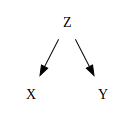

In [3]:
g = gr.Digraph("fork", node_attr={"color": "white"})

g.node("X")
g.node("Z")
g.node("Y")

g.edge("Z", "X")
g.edge("Z", "Y")
g

**The pipe:** $X$ and $Y$ are independent conditional on $Z$.

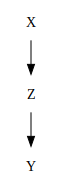

In [4]:
g = gr.Digraph("fork", node_attr={"color": "white"})

g.node("X")
g.node("Z")
g.node("Y")

g.edge("X", "Z")
g.edge("Z", "Y")
g

**The collider:** $X$ and $Y$ are independent, but conditioning on $Z$ may induce association between them.

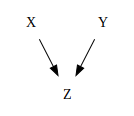

In [5]:
g = gr.Digraph("fork", node_attr={"color": "white"})

g.node("X")
g.node("Z")
g.node("Y")

g.edge("X", "Z")
g.edge("Y", "Z")
g

**The descendant:** $X$ and $Y$ are independent, but conditioning on $D$ may induce association (depending its relationship with $Z$).

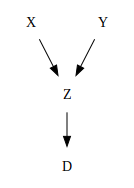

In [6]:
g = gr.Digraph("fork", node_attr={"color": "white"})

g.node("X")
g.node("Z")
g.node("Y")
g.node("D")

g.edge("X", "Z")
g.edge("Y", "Z")
g.edge("Z", "D")
g

### 6E4
How is a biased sample like conditioning on a collider?
Think of the example at the opening of the chapter.

---

Conditioning on a collider is like restricting attention to the subsample where the collider takes a particular value.
If the values of the collider are affected by the other two variables, then this is equivalent to selecting for certain (joint) values of those variables.
This is equivalent to selecting a biased (sub)sample.

## Medium

## Hard